[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/astrohack/blob/main/docs/tutorial_vla.ipynb)

![astrohack](_media/astrohack_logo.png)

Run CASA script yada yada yada

In [1]:
import os

from importlib.metadata import version

try:
    import astrohack
    
    print('AstroHACK version', version('astrohack'), 'already installed.')
except ImportError as e:
    print(e)
    print('Installing AstroHACK')
    
    os.system("pip install astrohack")
    
    import astrohack 
    print('astrohack version', version('astrohack'), ' installed.')

AstroHACK version 0.2.2 already installed.


In [2]:
from astrohack.astrohack_client import astrohack_local_client

client = astrohack_local_client(cores=2, memory_limit='8GB')
client

2023-08-21 16:00:03,793 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_term to True.
2023-08-21 16:00:03,794 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_to_file to False.
2023-08-21 16:00:03,795 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_file to hack_.
2023-08-21 16:00:03,795 - INFO     - astrohack - (_check_parms.py:135) - [_check_logger_parms]: Setting default log_level to INFO.
2023-08-21 16:00:03,796 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_term to False.
2023-08-21 16:00:03,797 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_to_file to False.
2023-08-21 16:00:03,797 - INFO     - astrohack - (_check_parms.py:135) - [_check_worker_logger_parms]: Setting default log_file to hack_.
2023-08-21 16:00:03,797 - INFO     - astrohack - (_

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38109,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:44501,Total threads: 1
Dashboard: http://127.0.0.1:43867/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:43601,


In [3]:
# For the moment use my cal table, definetely not the data to put online
cal_table = '/home/victor/work/Holography-1022/git-shared/locit-data-redux/2015-10-04-pha.cal'
root_dir= '/home/victor/work/Holography-1022/git-shared/locit-experiments/'


locit_name = root_dir+'2015-10-04.locit.zarr'
position_name = root_dir+'2015-10-04.position.zarr'

In [4]:
%%time
from astrohack.extract_locit import extract_locit
locit_mds = extract_locit(cal_table, 
                          locit_name=locit_name, 
                          ant_id=None, 
                          ddi=None, 
                          overwrite=True)

2023-08-21 16:00:06,256 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ant to all.
2023-08-21 16:00:06,257 - INFO     - astrohack - (_check_parms.py:135) - [extract_locit]: Setting default ddi to all.
2023-08-21 16:00:06,359 - WARNING  - astrohack - (_dio.py:43) - [extract_locit]: /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.locit.zarr will be overwritten.
2023-08-21 16:00:07,988 - INFO     - astrohack - (extract_locit.py:59) - [extract_locit]: Finished processing
CPU times: user 2 s, sys: 196 ms, total: 2.2 s
Wall time: 2.17 s


In [5]:
locit_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###     /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.locit.zarr     ###
####################################################################################################

Attributes:
+-------------------+--------------------------------------------------------------------------------------+
| Attribute         | Value                                                                                |
+-------------------+--------------------------------------------------------------------------------------+
| cal_table         | /home/victor/work/Holography-1022/git-shared/locit-data-redux/2015-10-04-pha.cal     |
| locit_name        | /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.locit.zarr |
| ant               | all             

In [6]:
locit_mds.print_source_table()


Sources:
+----+----------+---------------+----------------+---------------+----------------+
| Id | Name     | RA J2000      | DEC J2000      | RA precessed  | DEC precessed  |
+----+----------+---------------+----------------+---------------+----------------+
| 0  | 0423+418 | 04h23m56.010s | +41°50m02.714s | 04h24m14.459s | +41°51m58.210s |
| 1  | 0237+288 | 02h37m52.406s | +28°48m08.990s | 02h38m01.316s | +28°52m09.422s |
| 2  | 0125-000 | 01h25m28.843s | -00°05m55.963s | 01h25m30.077s | -00°00m57.567s |
| 3  | 2357-114 | 23h57m31.206s | -11°25m39.309s | 23h57m32.374s | -11°20m16.727s |
| 4  | 0240-231 | 02h40m08.175s | -23°09m15.731s | 02h40m03.408s | -23°05m09.388s |
| 5  | 0428-379 | 04h28m40.424s | -37°56m19.579s | 04h28m26.060s | -37°54m09.896s |
| 6  | 0416-188 | 04h16m36.545s | -18°51m08.339s | 04h16m30.822s | -18°48m46.832s |
| 7  | 0403+260 | 04h03m05.586s | +26°00m01.503s | 04h03m15.631s | +26°02m28.282s |
| 8  | 0359+509 | 03h59m29.747s | +50°57m50.162s | 03h59m53.955s |

In [7]:
locit_mds.print_antenna_table()


EVLA Antennae:
+------------+---------+-----------------+----------------+------------------------------+
| Name       | Station | Longitude       | Latitude       | Distance to earth center [m] |
+------------+---------+-----------------+----------------+------------------------------+
| ea10       | E04     | -107°37m00.791s | +33°53m59.737s | 6373577.384598857            |
| ea17       | N03     | -107°37m06.325s | +33°54m04.810s | 6373576.649522302            |
| ea06       | N04     | -107°37m06.461s | +33°54m06.099s | 6373576.460497183            |
| ea22       | W02     | -107°37m07.450s | +33°54m00.941s | 6373577.271939891            |
| ea11       | W03     | -107°37m08.907s | +33°54m00.126s | 6373577.387181953            |
| ea07       | N09     | -107°37m07.819s | +33°54m18.973s | 6373574.426538215            |
| ea14       | E08     | -107°36m48.899s | +33°53m55.132s | 6373576.777173386            |
| ea12       | N02     | -107°37m06.190s | +33°54m03.521s | 6373576.855755

In [8]:
locit_plot_folder = root_dir+'locit_mds_plots'

2023-08-21 16:00:08,502 - WARNING  - astrohack - (_dio.py:329) - [plot_source_positions]: Destination folder already exists, results may be overwritten


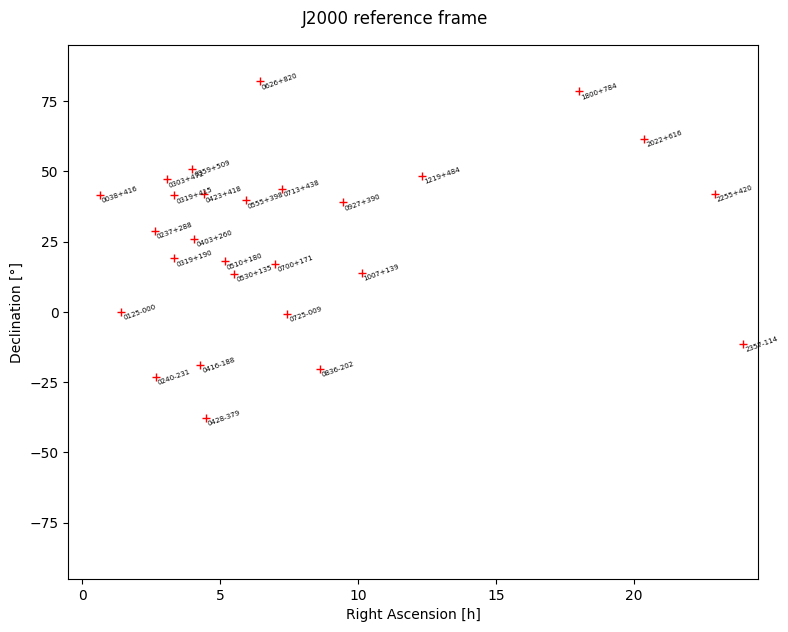

In [9]:
locit_mds.plot_source_positions(locit_plot_folder, 
                                display_labels=True, 
                                precessed=False)

2023-08-21 16:00:09,164 - INFO     - astrohack - (_check_parms.py:135) - [plot_source_positions]: Setting default precessed to False.
2023-08-21 16:00:09,180 - WARNING  - astrohack - (_dio.py:329) - [plot_antenna_positions]: Destination folder already exists, results may be overwritten


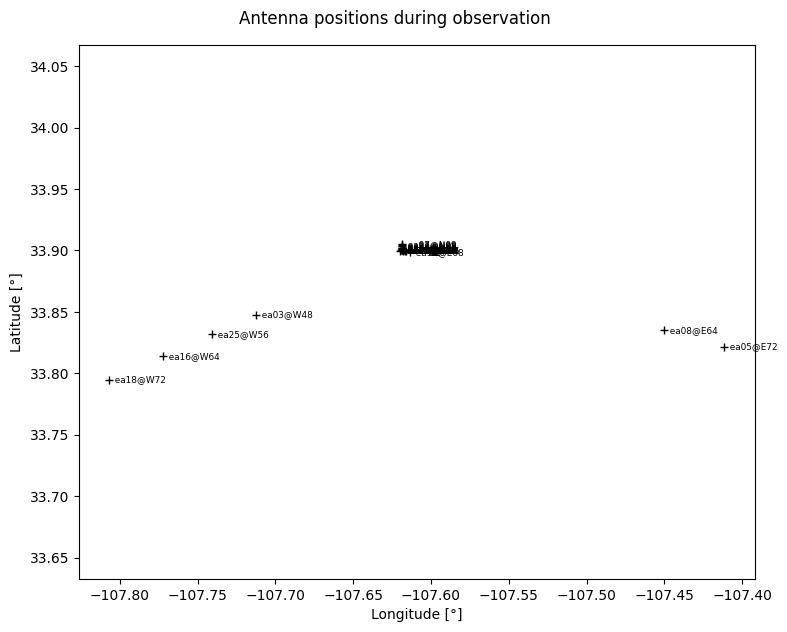

In [10]:
locit_mds.plot_antenna_positions(locit_plot_folder, 
                                 display_stations=True)

Now we proceed to actual fit yada yada yada

In [11]:
%%time
from astrohack.locit import locit
position_mds = locit(locit_name, 
                     position_name=position_name, 
                     elevation_limit=10.0, 
                     polarization='both', 
                     fit_engine='scipy',
                     fit_kterm=False, 
                     fit_slope=True, 
                     ant_id=None, 
                     ddi=None, 
                     combine_ddis=True,
                     parallel=True, 
                     overwrite=True)

2023-08-21 16:00:09,824 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ant to all.
2023-08-21 16:00:09,825 - INFO     - astrohack - (_check_parms.py:135) - [locit]: Setting default ddi to all.
2023-08-21 16:00:09,866 - WARNING  - astrohack - (_dio.py:43) - [locit]: /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.position.zarr will be overwritten.
2023-08-21 16:00:12,664 - INFO     - astrohack - (locit.py:105) - [locit]: Finished processing
CPU times: user 1.28 s, sys: 38.1 ms, total: 1.31 s
Wall time: 2.98 s


In [12]:
position_mds.summary()

####################################################################################################
###                                         Summary for:                                         ###
###   /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.position.zarr    ###
####################################################################################################

Attributes:
+-----------------+-----------------------------------------------------------------------------------------+
| Attribute       | Value                                                                                   |
+-----------------+-----------------------------------------------------------------------------------------+
| locit_name      | /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.locit.zarr    |
| position_name   | /home/victor/work/Holography-1022/git-shared/locit-experiments/2015-10-04.position.zarr |
| elevation_limit | 10.0         

In [13]:
position_export_folder = root_dir+'position_mds_export'

In [14]:
position_mds.export_fit_results(position_export_folder, 
                                position_unit='m', 
                                delay_unit='nsec',
                                time_unit='hour')


2023-08-21 16:00:12,850 - WARNING  - astrohack - (_dio.py:329) - [export_fit_results]: Destination folder already exists, results may be overwritten


In [15]:
with open(position_export_folder+'/locit_fit_results.txt', 'r') as file:
    for _ in range(30):
        print(file.readline()[:-1])

+----------+---------------------+----------------+-----------------+-----------------+------------------------+
| Antenna  | Fixed delay  [nsec] | X offset [m]   | Y offset [m]    | Z offset [m]    | Delay rate [nsec/hour] |
+----------+---------------------+----------------+-----------------+-----------------+------------------------+
| ant_ea10 | -0.003 ± 0.0        | 0.0011 ± 0.0   | 0.0014 ± 0.0    | 0.0006 ± 0.0    | 7.13e-05 ± 0.0         |
| ant_ea17 | 0.096 ± 0.0         | -0.023 ± 0.0   | 0.01 ± 0.0      | -0.014 ± 0.0    | -0.011 ± 0.0           |
| ant_ea06 | 0.048 ± 0.0         | -0.016 ± 0.0   | 0.0037 ± 0.0    | -0.0042 ± 0.0   | 0.00058 ± 0.0          |
| ant_ea22 | -0.0048 ± 0.0       | 0.0015 ± 0.0   | 0.00098 ± 0.0   | -0.00038 ± 0.0  | -0.00027 ± 0.0         |
| ant_ea11 | -0.000235 ± 0.0     | -0.00099 ± 0.0 | 0.00066 ± 0.0   | -0.000289 ± 0.0 | 0.0015 ± 0.0           |
| ant_ea07 | -0.023 ± 0.0        | 0.0062 ± 0.0   | -0.0059 ± 0.0   | 0.0025 ± 0.0    | 0.0054 ±

In [16]:
position_plot_folder = root_dir+'position_mds_plots'

2023-08-21 16:00:12,885 - WARNING  - astrohack - (_dio.py:329) - [plot_sky_coverage]: Destination folder already exists, results may be overwritten


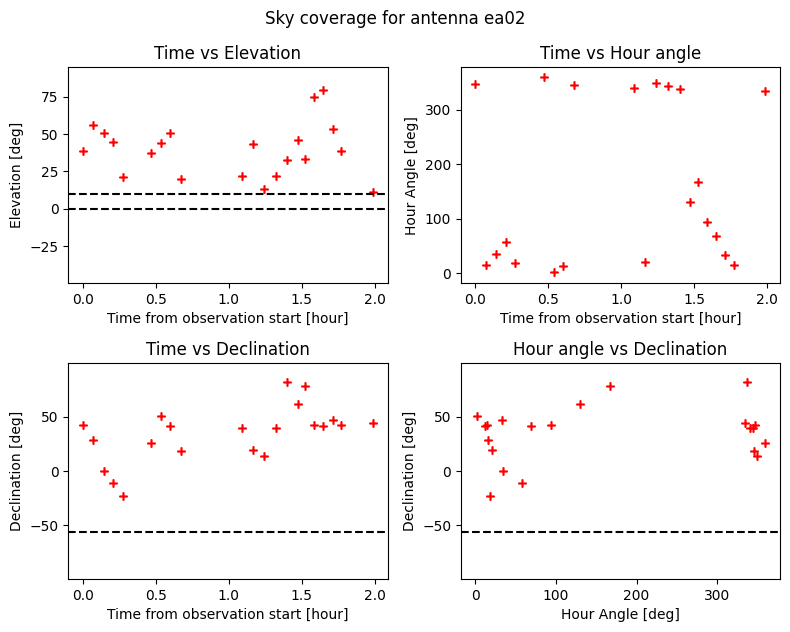

In [17]:
position_mds.plot_sky_coverage(position_plot_folder, 
                               ant_id='ea02',
                               ddi=1,
                               time_unit='hour', 
                               angle_unit='deg', 
                               display=True,
                               figure_size=None,
                               dpi=300,
                               parallel=False)

2023-08-21 16:00:14,106 - WARNING  - astrohack - (_dio.py:329) - [plot_delays]: Destination folder already exists, results may be overwritten


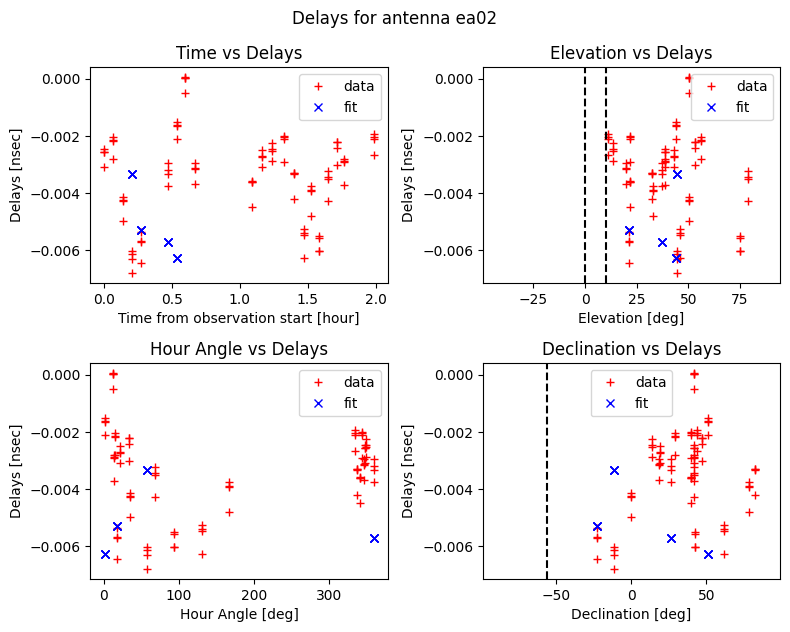

In [18]:
position_mds.plot_delays(position_plot_folder, 
                        ant_id='ea02',
                        ddi=1,
                        time_unit='hour',
                        angle_unit='deg',
                        delay_unit='nsec',
                        plot_fit=True,
                        display=True,
                        figure_size=None,
                        dpi=300,
                        parallel=False)